In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

In [ ]:
# !pip install numpy pandas tensorflow tensorflow-keras gym talib datetime random json
# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
# import talib as ta
# #In case the zip doesnt work, here is a backup version in google colab: https://colab.research.google.com/drive/1EuM_4R_LVxCvMgpIKq-Yo73IEJq25RyP?usp=sharing
# # You'll need to upload the AAPL_train and AAPL_Test csvs.

In [2]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
            np.array(self.actions),\
            np.array(self.probs),\
            np.array(self.vals),\
            np.array(self.rewards),\
            np.array(self.dones),\
            batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [3]:
class ActorNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorNetwork, self).__init__()

        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.flatten = Flatten()
        self.fc3 = Dense(n_actions, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.flatten(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=256, fc2_dims=256):
        super(CriticNetwork, self).__init__()
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.flatten = Flatten()
        self.q = Dense(1, activation=None)

    def call(self, state):
        x = self.fc1(state)
        x = self.flatten(x)
        x = self.fc2(x)
        q = self.q(x)

        return q

In [4]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003,
                 gae_lambda=0.95, policy_clip=0.2, batch_size=64,
                 n_epochs=10, chkpt_dir='models/'):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.chkpt_dir = chkpt_dir

        self.actor = ActorNetwork(n_actions)
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic = CriticNetwork()   
        self.critic.compile(optimizer=Adam(learning_rate=alpha))
        self.memory = PPOMemory(batch_size)

    def store_transition(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save(self.chkpt_dir + 'actor')
        self.critic.save(self.chkpt_dir + 'critic')

    def load_models(self):
        print('... loading models ...')
        self.actor = keras.models.load_model(self.chkpt_dir + 'actor')
        self.critic = keras.models.load_model(self.chkpt_dir + 'critic')

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])
        probs = self.actor(state)   
        #probs_list=(probs.numpy().tolist())[0] #This is the probability distribution

        dist = tfp.distributions.Categorical(probs) #Changed from tfp.distributions.Categorical where previous is discrete space
        action = dist.sample()
        log_prob = dist.log_prob(action) #There are slight errors in the calculation, i think it may effect the end result
        value = self.critic(state)
        action = action.numpy()[0]
        value = value.numpy()[0]
        log_prob=log_prob.numpy()[0]
        return [action, log_prob, value]

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, dones_arr, batches = \
                self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1] * (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t

            for batch in batches:
                with tf.GradientTape(persistent=True) as tape:
                    states = tf.convert_to_tensor(state_arr[batch])
                    old_probs = tf.convert_to_tensor(old_prob_arr[batch])
                    actions = tf.convert_to_tensor(action_arr[batch])

                    probs = self.actor(states)
                    dist = tfp.distributions.Categorical(probs)
                    new_probs = dist.log_prob(actions)

                    critic_value = self.critic(states)

                    critic_value = tf.squeeze(critic_value, 1)

                    #prob_ratio = tf.math.exp(new_probs - old_probs)
                    prob_ratio = tf.math.exp(tf.cast(new_probs, tf.float32) - tf.cast(old_probs, tf.float32))

                    weighted_probs = advantage[batch] * prob_ratio
                    clipped_probs = tf.clip_by_value(prob_ratio,
                                                     1-self.policy_clip,
                                                     1+self.policy_clip)
                    weighted_clipped_probs = clipped_probs * advantage[batch]
                    actor_loss = -tf.math.minimum(weighted_probs,
                                                  weighted_clipped_probs)
                    actor_loss = tf.math.reduce_mean(actor_loss)

                    returns = advantage[batch] + values[batch]
                    critic_loss = keras.losses.MSE(critic_value, returns)

                actor_params = self.actor.trainable_variables
                actor_grads = tape.gradient(actor_loss, actor_params)
                critic_params = self.critic.trainable_variables
                critic_grads = tape.gradient(critic_loss, critic_params)
                self.actor.optimizer.apply_gradients(
                        zip(actor_grads, actor_params))
                self.critic.optimizer.apply_gradients(
                        zip(critic_grads, critic_params))

        self.memory.clear_memory()


In [5]:
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\George Xu UCLA\AppData\Local\Temp\ipykernel_7216\239407893.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  advantage[t] = a_t


... saving models ...
INFO:tensorflow:Assets written to: models/actor\assets


INFO:tensorflow:Assets written to: models/actor\assets


INFO:tensorflow:Assets written to: models/critic\assets


INFO:tensorflow:Assets written to: models/critic\assets


Step: 76
Balance: 4588.8719897376695
Shares held: 143 (Total sold: 81)
Avg cost for held shares: 37.09571967967366 (Total sales value: 2951.210796427263)
Net worth: 9801.032764808051 (Max net worth: 10017.866241509448)
Profit: -198.96723519194893


C:\Users\George Xu UCLA\AppData\Local\Temp\ipykernel_7216\239407893.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  advantage[t] = a_t


Step: 416
Balance: 3346.125074745495
Shares held: 121 (Total sold: 33)
Avg cost for held shares: 54.09576601413967 (Total sales value: 1711.5414115895314)
Net worth: 9188.824780981113 (Max net worth: 10000)
Profit: -811.1752190188872
Step: 1147
Balance: 3974.2280025842424
Shares held: 40 (Total sold: 22)
Avg cost for held shares: 147.44914220574057 (Total sales value: 3181.8602122803964)
Net worth: 9691.508485164242 (Max net worth: 10054.342966896944)
Profit: -308.4915148357577
Step: 888
Balance: 3114.892697024517
Shares held: 59 (Total sold: 16)
Avg cost for held shares: 116.21869011728778 (Total sales value: 1895.49588364078)
Net worth: 10044.298897432234 (Max net worth: 10296.967482458236)
Profit: 44.2988974322343
Step: 436
Balance: 2260.642152500901
Shares held: 163 (Total sold: 44)
Avg cost for held shares: 46.68419096485364 (Total sales value: 2032.7583371519338)
Net worth: 9014.664970034195 (Max net worth: 10021.130044066118)
Profit: -985.335029965805
Step: 1043
Balance: 3920.83

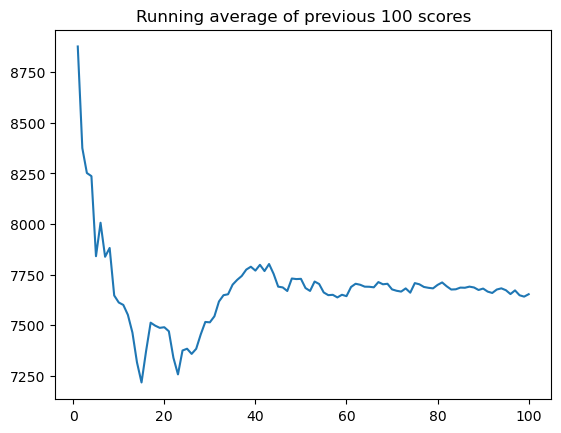

In [6]:
import gym
from StockTradingEnv import StockTradingEnv
import talib as ta
from datetime import datetime

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

if __name__ == '__main__':

    df = pd.read_csv('./TSLA_train.csv')
    df = df.sort_values('Date')
    df['Cum_Vol'] = df['Volume'].cumsum()
    df['Cum_Vol_Price'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close'] ) /3).cumsum()
    df['VWAP'] = df['Cum_Vol_Price'] / df['Cum_Vol']
    df['RSI'] = ta.RSI(df['Close'], timeperiod=14)

    df.dropna(inplace=True)
    df = df.sort_values('Date')
    df = df.reset_index()
    
    # The algorithms require a vectorized environment to run
    env = StockTradingEnv(df)
    
    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003 #0.1-~35k ,0.001~30k
    n_games = 100
    learn_iters = 0
    avg_score = 0
    n_steps = 0
    
    agent = Agent(n_actions=3, batch_size=batch_size,
                  alpha=alpha, n_epochs=n_epochs,
                  input_dims=env.observation_space.shape)

    best_score = env.reward_range[0]
    score_history = []

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action_prob_val= agent.choose_action(np.expand_dims(observation, axis=0)) # list containing action, prob, val
            action=action_prob_val[0] #int
            prob=action_prob_val[1]   #float
            val=action_prob_val[2]    
            observation_, reward, done, info = env.step(action_prob_val)
            n_steps += 1
            score += reward
            agent.store_transition(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        
        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()
        tf.summary.scalar('reward summary', data=avg_score,
                          
                           step=i)
        # print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
        #       'time_steps', n_steps, 'learning_steps', learn_iters)
        env.render()


        
    filename = 'PPO_trading_view.png'
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, './30min_train.jpg')


In [7]:
import gym
import talib as ta
from Test_Env import TestEnv
from datetime import datetime

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

if __name__ == '__main__':

    df = pd.read_csv('./TSLA_test.csv')
    df = df.sort_values('Date')
    df['Cum_Vol'] = df['Volume'].cumsum()
    df['Cum_Vol_Price'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close'] ) /3).cumsum()
    df['VWAP'] = df['Cum_Vol_Price'] / df['Cum_Vol']
    df['RSI'] = ta.RSI(df['Close'], timeperiod=14)

    df.dropna(inplace=True)
    df = df.sort_values('Date')
    df = df.reset_index()
    
    # The algorithms require a vectorized environment to run
    
    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003
    learn_iters = 0
    net_worths = []  # Array to store the final net worth from each simulation

    for i in range(10):  # Run 100 simulations
        env = TestEnv(df)  # Initialize the environment with the dataframe
        agent = Agent(n_actions=3, batch_size=batch_size, alpha=alpha, n_epochs=n_epochs,
                      input_dims=env.observation_space.shape)
        agent.load_models()  
        observation = env.reset()
        done = False
        while not done:
            action_prob_val = agent.choose_action(np.expand_dims(observation, axis=0))
            observation, reward, done, info = env.step(action_prob_val)
        if env.net_worth is not None:
            net_worths.append(float(env.net_worth))  # Record the final net worth after the simulation is done
        print(f"Simulation {i+1}: Final net worth {env.net_worth}")
    save=list(net_worths)
    # Now, net_worths contains the final net worth from each simulation
    print(f"Average final net worth after 100 simulations: {np.mean(net_worths)}")
       

... loading models ...



c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")



Simulation 1: Final net worth 8910.697562989211
... loading models ...


c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Simulation 2: Final net worth 8991.616017553106
... loading models ...


c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Simulation 3: Final net worth 9020.217817245928
... loading models ...


c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Simulation 4: Final net worth 9181.548908091598
... loading models ...


c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Simulation 5: Final net worth 9064.863225479192
... loading models ...


c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Simulation 6: Final net worth 9259.964018318438
... loading models ...


c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Simulation 7: Final net worth 9282.82440189986
... loading models ...


c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Simulation 8: Final net worth 9172.156611038474
... loading models ...


c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Simulation 9: Final net worth 8963.896313397752
... loading models ...


c:\Anaconda\envs\FinAnnaRedo\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Simulation 10: Final net worth 8941.143933193403
Average final net worth after 100 simulations: 9078.892880920697


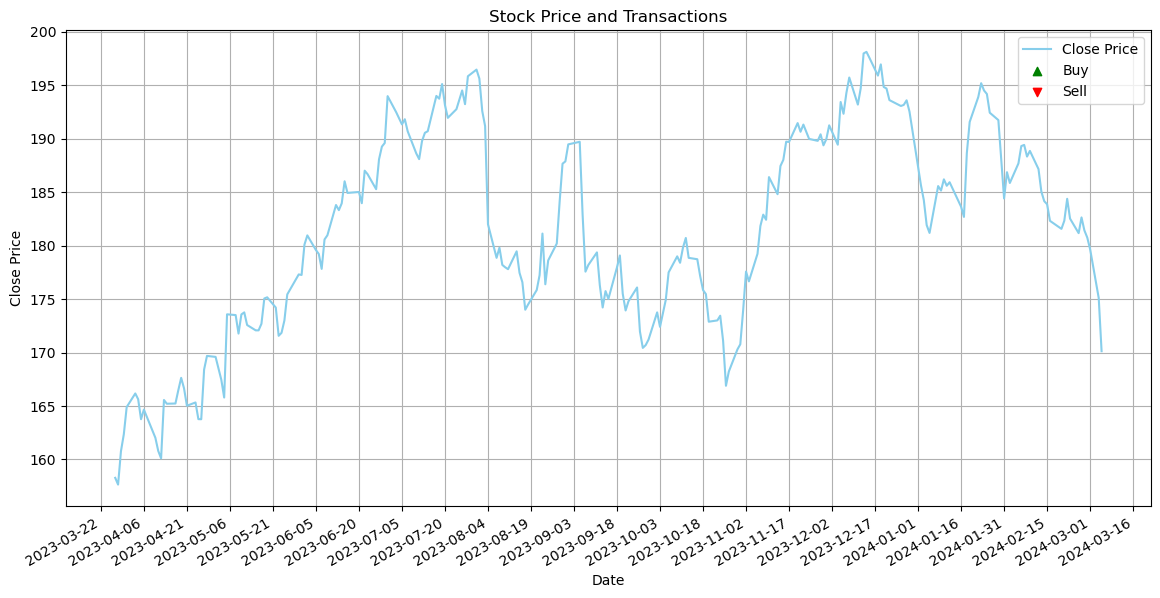

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming simulation has been run and env.transactions is populated

# Convert transactions to DataFrame for easier plotting
transactions_df = pd.DataFrame(env.transactions, columns=['Date', 'Close', 'Action', 'Quantity'])
buy_transactions = transactions_df[(transactions_df['Action'] == 'buy') & (transactions_df['Quantity'] > 10)]
sell_transactions = transactions_df[(transactions_df['Action'] == 'sell') & (transactions_df['Quantity'] > 10)]

# Convert date strings to datetime objects
df['Date'] = pd.to_datetime(df['Date'])
buy_transactions['Date'] = pd.to_datetime(buy_transactions['Date'])
sell_transactions['Date'] = pd.to_datetime(sell_transactions['Date'])

plt.figure(figsize=(14, 7))

# Plot closing prices
plt.plot(df['Date'], df['Close'], label='Close Price', color='skyblue')

# Plot buy transactions
plt.scatter(buy_transactions['Date'], buy_transactions['Close'], label='Buy', color='green', marker='^', alpha=1)

# Plot sell transactions
plt.scatter(sell_transactions['Date'], sell_transactions['Close'], label='Sell', color='red', marker='v', alpha=1)

plt.title('Stock Price and Transactions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Adjust interval as needed
plt.gcf().autofmt_xdate()  # Beautify the x-labels
plt.grid(True)
plt.show()


Statistics=0.915, p=0.318
Variance of the list: 135.5469162901091
Sample looks Gaussian (fail to reject H0)


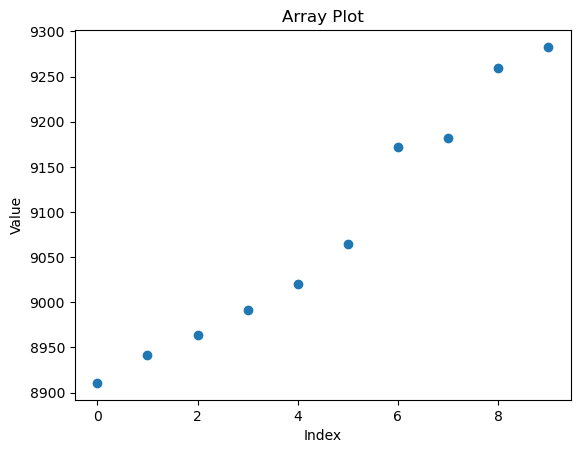

In [9]:
from scipy.stats import shapiro
import statistics


net_worths.sort()
plt.scatter(range(len(net_worths)), net_worths)
stat, p = shapiro(net_worths)
print('Statistics=%.3f, p=%.3f' % (stat, p))
print("Variance of the list:", statistics.stdev(net_worths))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
# Adding title
plt.title('Array Plot')

# Adding labels
plt.xlabel('Index')
plt.ylabel('Value')

# Display the plot
plt.show()